# SOTA Activation Zone Generator
By: Ara Kourchians - N6ARA

In [69]:
#summit_ref = "W7WLC001"    # SOTA Summit Reference (no slashes or dash)
#summit_lat = 46.1911      # Latitude in degrees (Source: SOTA Database)
#summit_long = -122.1944   # Longitude in degrees (Source: SOTA Database)
#summit_alt = 2550          # Altitude in meters (Source: SOTA Database)

summit_ref = "W6CT225"    # SOTA Summit Reference (no slashes or dash)
summit_lat = 34.1636      # Latitude in degrees (Source: SOTA Database)
summit_long = -118.1967   # Longitude in degrees (Source: SOTA Database)
summit_alt = 576          # Altitude in meters (Source: SOTA Database)

deg_delta = 0.040             # Increase this parameter if the summit AZ is large
sota_summit_alt_thres = 25    # Per SOTA Rules April 2015 - Activation Zone is within 25 vertical meters of peak

In [70]:
# Install dependencies if you don't already have them by uncommenting the following:
#import sys
#!{sys.executable} -m pip install osgeo
#!{sys.executable} -m pip install gdal
#!{sys.executable} -m pip install elevation
#!{sys.executable} -m pip install descartes
#!{sys.executable} -m pip install alphashape

In [71]:
from osgeo import gdal
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import elevation

from descartes import PolygonPatch
import alphashape

In [72]:
# Generate the extent
summit_lat_min = float('{:.8f}'.format(summit_lat-deg_delta))
summit_lat_max = float('{:.8f}'.format(summit_lat+deg_delta))
summit_long_min = float('{:.8f}'.format(summit_long-deg_delta))
summit_long_max = float('{:.8f}'.format(summit_long+deg_delta))

summit_extent = [summit_long_min,summit_long_max,summit_lat_min,summit_lat_max]
print(summit_extent)

# Set SOTA Altitude AZ (Activation Zone) Cutoff
summit_alt_az_min = summit_alt - sota_summit_alt_thres
print("AZ Altitude Cutoff: ", summit_alt_az_min)

# Download DEM
!mkdir data
!eio clip -o data/{summit_ref}-30m-DEM.tif --bounds {summit_long_min} {summit_lat_min} {summit_long_max} {summit_lat_max}

[-118.2367, -118.1567, 34.1236, 34.2036]
AZ Altitude Cutoff:  551
mkdir: data: File exists
make: Nothing to be done for `download'.
make: Nothing to be done for `all'.
cp SRTM1.vrt SRTM1.8d236e29373e47e8b2522c88c8b04aa2.vrt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin -118.2367 34.2036 -118.1567 34.1236 SRTM1.8d236e29373e47e8b2522c88c8b04aa2.vrt /Users/arko/GitHub/azgen/data/W6CT225-30m-DEM.tif
rm -f SRTM1.8d236e29373e47e8b2522c88c8b04aa2.vrt


In [73]:
# Load DEM
filename = "data/" + summit_ref + "-30m-DEM.tif"
gdal_data = gdal.Open(filename)
gdal_band = gdal_data.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()

# convert to a numpy array
dem = gdal_data.ReadAsArray().astype(np.float)

# replace missing values if necessary
if np.any(dem == nodataval):
    dem[dem == nodataval] = np.nan

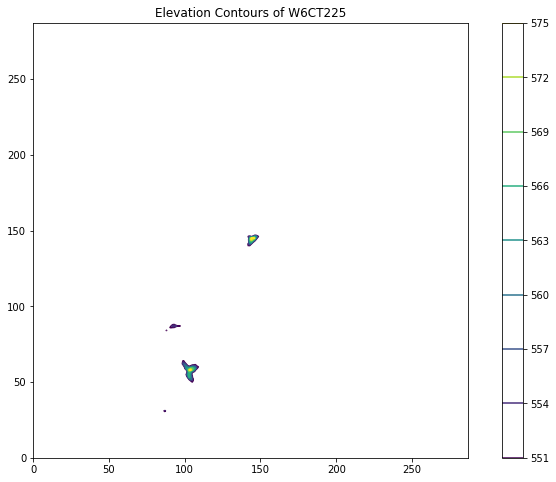

In [74]:
# Plot DEM data with Matplotlib contour
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contour(dem, cmap = "viridis", 
            levels = list(range(summit_alt_az_min, summit_alt, 3)))
plt.title("Elevation Contours of " + summit_ref)
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

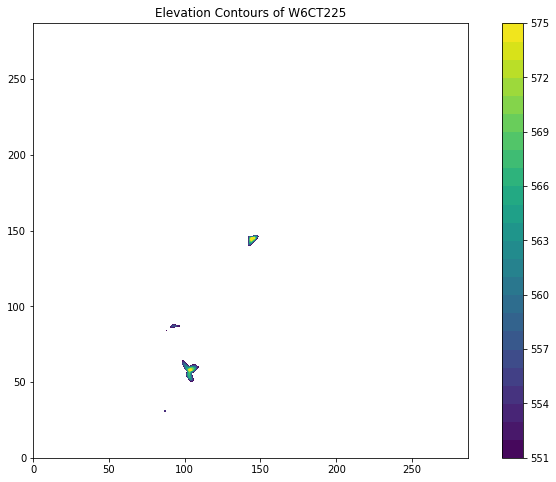

In [75]:
# Plot DEM data with Matplotlib gradients
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contourf(dem, cmap = "viridis", 
            levels = list(range(summit_alt_az_min, summit_alt, 1)))
plt.title("Elevation Contours of " + summit_ref)
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

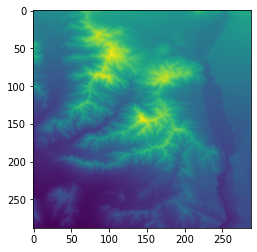

Data Array Size: (288, 288)
[[347. 349. 350. ... 403. 403. 402.]
 [345. 346. 347. ... 402. 401. 401.]
 [343. 344. 345. ... 401. 401. 401.]
 ...
 [168. 168. 168. ... 236. 235. 235.]
 [172. 170. 169. ... 235. 235. 234.]
 [176. 172. 171. ... 235. 234. 234.]]


In [76]:
# Plot raw DEM data
plt.imshow(dem)
plt.show()
print("Data Array Size:", dem.shape)
print(dem)

144 144


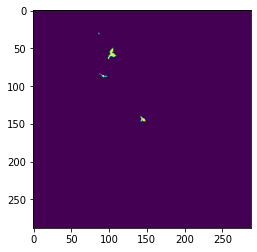

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [77]:
# Plot Activation Zone Altitude Mask (all data points at or above alt cutoff)
num_x, num_y = dem.shape

center_x = int(num_x/2)
center_y = int(num_y/2)
print(center_x, center_y)

az_mask = np.zeros((num_x, num_y))

# If the requested summit altitude is too high, use the DEM altitude as the summit altitude
if ( summit_alt - dem[center_x,center_y] > sota_summit_alt_thres - 1 ):
    print("REQUEST ALT: ", summit_alt)
    print("DEM ALT: ", dem[center_x,center_y])
    summit_alt_az_min = dem[center_x,center_y] - sota_summit_alt_thres
    print("Using DEM ALT...")
    
for x in range(num_x):
    for y in range(num_y):
        if dem[x,y] >= summit_alt_az_min:
            az_mask[x,y] = 1

plt.imshow(az_mask)
plt.show()
print(az_mask)

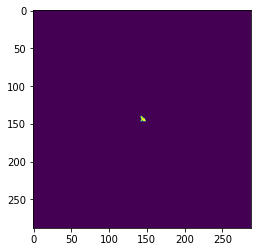

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


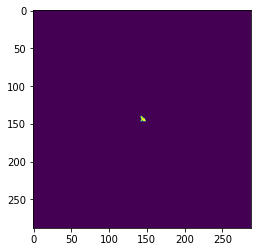

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [78]:
# Filter data points that are both within the 
# activation zone altitude and are connected to the summit
az_mask_s = np.zeros((num_x, num_y))
az_mask_s[center_x,center_y] = 2 

az = np.zeros((num_x, num_y))

# Start at the summit (center) and expand outward until outside the AZ
#    0 = Unassigned or outside of AZ
#    1 = Within AZ
#    2 = Marked for searching outward
while 2 in az_mask_s:
    for x in range(num_x):
        for y in range(num_y):
            if az_mask_s[x,y] == 2 and az_mask[x,y] == 1:
                
                if az_mask_s[x+1,y+1] == 0 and az_mask[x+1,y+1] == 1:
                    az_mask_s[x+1,y+1] = 2
                
                if az_mask_s[x+1,y-1] == 0 and az_mask[x+1,y-1] == 1:
                    az_mask_s[x+1,y-1] = 2
                
                if az_mask_s[x-1,y+1] == 0 and az_mask[x-1,y+1] == 1:
                    az_mask_s[x-1,y+1] = 2
                    
                if az_mask_s[x-1,y-1] == 0 and az_mask[x-1,y-1] == 1:
                    az_mask_s[x-1,y-1] = 2

                if az_mask_s[x+1,y] == 0 and az_mask[x+1,y] == 1:
                    az_mask_s[x+1,y] = 2
                
                if az_mask_s[x-1,y] == 0 and az_mask[x-1,y-1] == 1:
                    az_mask_s[x-1,y] = 2
                
                if az_mask_s[x,y+1] == 0 and az_mask[x,y+1] == 1:
                    az_mask_s[x,y+1] = 2
                
                if az_mask_s[x,y-1] == 0 and az_mask[x,y-1] == 1:
                    az_mask_s[x,y-1] = 2

            if az_mask_s[x,y] == 2:
                az_mask_s[x,y] = 1

# The following is meant for future use. Copying az_mask_s directly to az works just as well.
for x in range(num_x):
    for y in range(num_y):
        if az_mask_s[x,y] == 1:
            az[x,y] = 1


# Plot AZ Mask
plt.imshow(az_mask_s)
plt.show()
print(az_mask_s)

# Plot AZ
plt.imshow(az)
plt.show()
print(az)

In [79]:
# Generate Latitude and Longitude array (shares indices with az)

# Calculate lat/long step per index
az_lat_step = (summit_lat_max-summit_lat_min)/num_y
az_long_step = (summit_long_max-summit_long_min)/num_x

print(az_lat_step)
print(az_long_step)

lat = np.zeros((num_x, num_y))
long = np.zeros((num_x, num_y))

# Calculate Lat/Long array
for x in range(num_x):
    for y in range(num_y):
        lat[x,y] = summit_lat_max - (az_lat_step*x)
        long[x,y] = summit_long_min + (az_long_step*y)

print(lat)
print(long)

0.00027777777777777187
0.00027777777777777187
[[34.2036     34.2036     34.2036     ... 34.2036     34.2036
  34.2036    ]
 [34.20332222 34.20332222 34.20332222 ... 34.20332222 34.20332222
  34.20332222]
 [34.20304444 34.20304444 34.20304444 ... 34.20304444 34.20304444
  34.20304444]
 ...
 [34.12443333 34.12443333 34.12443333 ... 34.12443333 34.12443333
  34.12443333]
 [34.12415556 34.12415556 34.12415556 ... 34.12415556 34.12415556
  34.12415556]
 [34.12387778 34.12387778 34.12387778 ... 34.12387778 34.12387778
  34.12387778]]
[[-118.2367     -118.23642222 -118.23614444 ... -118.15753333
  -118.15725556 -118.15697778]
 [-118.2367     -118.23642222 -118.23614444 ... -118.15753333
  -118.15725556 -118.15697778]
 [-118.2367     -118.23642222 -118.23614444 ... -118.15753333
  -118.15725556 -118.15697778]
 ...
 [-118.2367     -118.23642222 -118.23614444 ... -118.15753333
  -118.15725556 -118.15697778]
 [-118.2367     -118.23642222 -118.23614444 ... -118.15753333
  -118.15725556 -118.156977

In [80]:
# Print all AZ data points
for x in range(num_x):
    for y in range(num_y):
        if az[x,y] == 1:
            print("Lat: ", lat[x,y], "Long: ", long[x,y], "Alt: ", dem[x,y])

Lat:  34.16471111111111 Long:  -118.19725555555556 Alt:  552.0
Lat:  34.16471111111111 Long:  -118.19697777777778 Alt:  550.0
Lat:  34.164433333333335 Long:  -118.19725555555556 Alt:  555.0
Lat:  34.164433333333335 Long:  -118.19697777777778 Alt:  558.0
Lat:  34.164433333333335 Long:  -118.19669999999999 Alt:  549.0
Lat:  34.16415555555556 Long:  -118.19697777777778 Alt:  565.0
Lat:  34.16415555555556 Long:  -118.19669999999999 Alt:  563.0
Lat:  34.16415555555556 Long:  -118.19642222222222 Alt:  549.0
Lat:  34.16387777777778 Long:  -118.19697777777778 Alt:  567.0
Lat:  34.16387777777778 Long:  -118.19669999999999 Alt:  570.0
Lat:  34.16387777777778 Long:  -118.19642222222222 Alt:  561.0
Lat:  34.16387777777778 Long:  -118.19614444444444 Alt:  552.0
Lat:  34.16387777777778 Long:  -118.19586666666666 Alt:  540.0
Lat:  34.1636 Long:  -118.19697777777778 Alt:  568.0
Lat:  34.1636 Long:  -118.19669999999999 Alt:  577.0
Lat:  34.1636 Long:  -118.19642222222222 Alt:  571.0
Lat:  34.1636 Long:

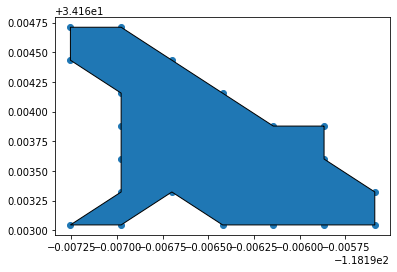

POLYGON ((-118.1958666666667 34.16387777777778, -118.1958666666667 34.1636, -118.1955888888889 34.16332222222223, -118.1955888888889 34.16304444444444, -118.1958666666667 34.16304444444444, -118.1961444444444 34.16304444444444, -118.1964222222222 34.16304444444444, -118.1967 34.16332222222223, -118.1969777777778 34.16304444444444, -118.1972555555556 34.16304444444444, -118.1969777777778 34.16332222222223, -118.1969777777778 34.1636, -118.1969777777778 34.16387777777778, -118.1969777777778 34.16415555555556, -118.1972555555556 34.16443333333333, -118.1972555555556 34.16471111111111, -118.1969777777778 34.16471111111111, -118.1967 34.16443333333333, -118.1964222222222 34.16415555555556, -118.1961444444444 34.16387777777778, -118.1958666666667 34.16387777777778))


In [81]:
# Generate GPX and Activation Zone shapefile
from osgeo import ogr
from osgeo import osr
import fileinput
from datetime import datetime
import os

srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)

driver = ogr.GetDriverByName("GPX")

# Remove output shapefile if it already exists
if os.path.exists('./data/' + summit_ref + '.gpx'):
    driver.DeleteDataSource('./data/' + summit_ref + '.gpx')

    
out = driver.CreateDataSource('./data/' + summit_ref + '.gpx')

# layer creation: if you use 'track_points', points are accepted
oL = out.CreateLayer("track_points", srs, ogr.wkbPoint)

# Add all lat/long points of AZ
for x in range(num_x):
    for y in range(num_y):
        if az[x,y] == 1:

            # create point
            p = ogr.Geometry(ogr.wkbPoint)
            # initialise point with coordinates
            p.AddPoint(float(long[x,y]), float(lat[x,y]))

            # prepare new "feature" using the layer's "feature definition", 
            # initialize it by setting geometry and necessary field values
            featureDefn = oL.GetLayerDefn()
            oF = ogr.Feature(featureDefn)
            oF.SetGeometry(p)
            oF.SetField("track_fid", "1")
            oF.SetField("track_seg_id", "1")    

            # adapt this according to the timestamp format of your data source
            oL.CreateFeature(oF)    

# Collect all Geometry
geomcol = []

# Add all lat/long points to generate a AZ polygon using convexhull
for x in range(num_x):
    for y in range(num_y):
        if az[x,y] == 1:

            # 
            geomcol.append( (float(long[x,y]), float(lat[x,y])) )
            
#print(geomcol, "\n")

# AZ Polygon Geometry using Concave Hull
az_shape = alphashape.alphashape(geomcol, 4000.0)

fig, ax = plt.subplots()
ax.scatter(*zip(*geomcol))
ax.add_patch(PolygonPatch(az_shape, alpha=1.0))
plt.show()

print(az_shape)